In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.patches as patches

from scipy.stats import gaussian_kde as GKDE
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.stats import multivariate_normal as mvn

import weightedCDFs as wCDFs
import weights

import matplotlib as mpl

In [2]:
mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

## Problem setup

In [3]:
random.seed(20)

In [4]:
l = 2.
kappa = 1.

In [5]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [6]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

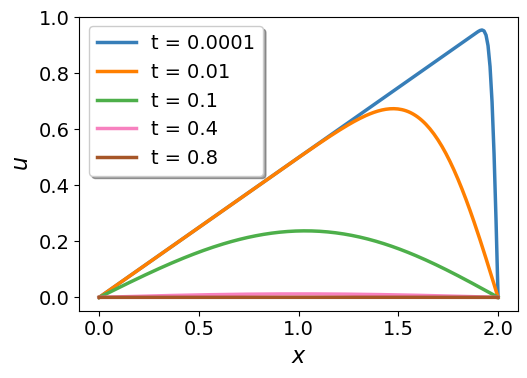

In [7]:
for t in ts:

    u_N = u(N, x, t, l, kappa)
    plt.plot(x, u_N, label='t = ' + str(t));

plt.legend(loc='upper left', shadow=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_sol.png', bbox_inches='tight')

In [8]:
ts = [.01, 0.1]
sensor_loc = [1.2, 1.0]

## Setup the standard DCI problem

In [9]:
n_init_samples = 2000

delta_l = 0.1
delta_kappa = 0.5

init_samples = np.random.uniform(0, 1, (n_init_samples,2))
init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

In [10]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc[0], ts[0], XX[count,:], YY[count,:])

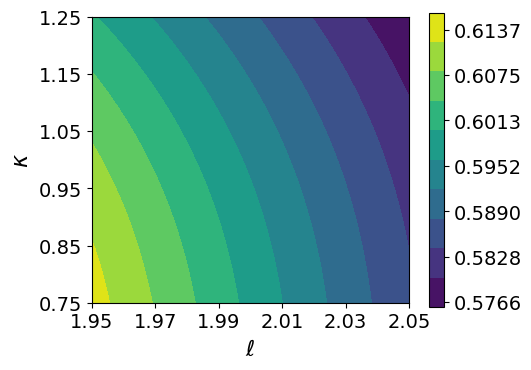

In [11]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ),
                                                             np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/contours.png', bbox_inches='tight')

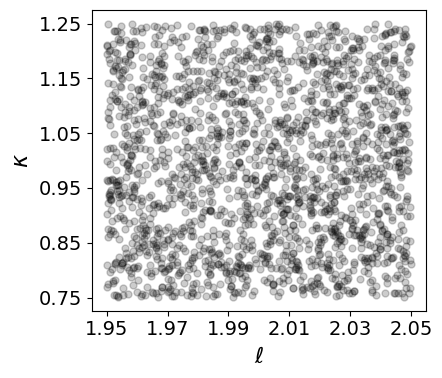

In [12]:
plt.scatter(init_samples[:,0], init_samples[:,1], alpha=0.2, color='k')
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_init_samples.png', bbox_inches='tight')

In [13]:
pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc[count], t, init_samples[:,0], init_samples[:,1])
    
pred_KDE = GKDE(pred_samples.T)

In [14]:
obs_dist = mvn([0.595, 0.25],[[0.000001, 0.0],[0.0, 0.0001]])

n_obs_samples = 8000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples.T)

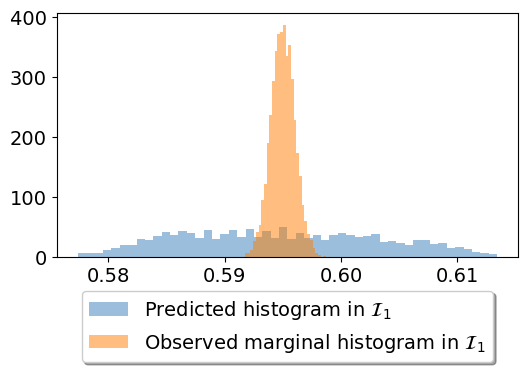

In [15]:
plt.hist(pred_samples[:,0], alpha=0.5,
         label=r'Predicted histogram in $\mathcal{I}_1$', bins=50, density=True)
plt.hist(obs_samples[:,0], alpha=0.5,
         label=r'Observed marginal histogram in $\mathcal{I}_1$', bins=30, density=True)
# plt.hist(obs_samples[:,0], obs_samples[:,1], alpha=0.5, label='Observed samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True)
plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_dspace1.png', bbox_inches='tight')

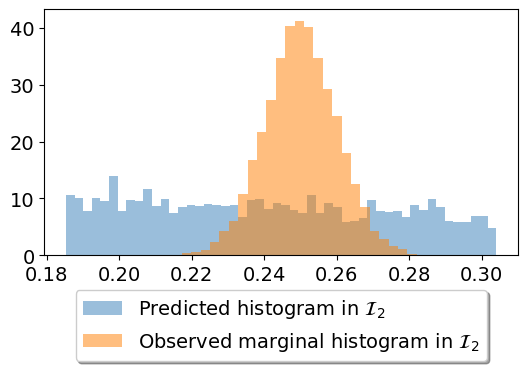

In [16]:
plt.hist(pred_samples[:,1], alpha=0.5,
         label=r'Predicted histogram in $\mathcal{I}_2$', bins=50, density=True)
plt.hist(obs_samples[:,1], alpha=0.5,
         label=r'Observed marginal histogram in $\mathcal{I}_2$', bins=30, density=True)
# plt.hist(obs_samples[:,0], obs_samples[:,1], alpha=0.5, label='Observed samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True)
plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_dspace2.png', bbox_inches='tight')

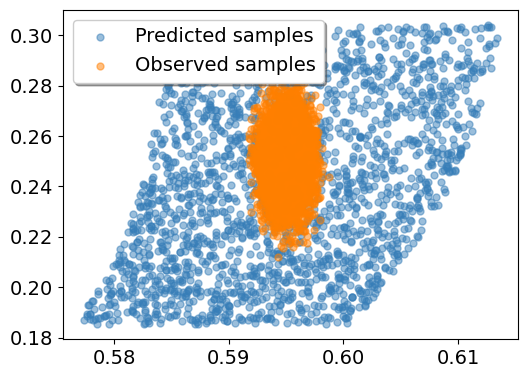

In [17]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], alpha=0.5, label='Predicted samples')
plt.scatter(obs_samples[:,0], obs_samples[:,1], alpha=0.5, label='Observed samples')
plt.legend(shadow=True)
plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_dspace.png', bbox_inches='tight')

In [18]:
print(np.shape(pred_samples))

(2000, 2)


## Density-based solution

In [19]:
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 1.0637970565429722


In [20]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

In [21]:
update_inds = rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

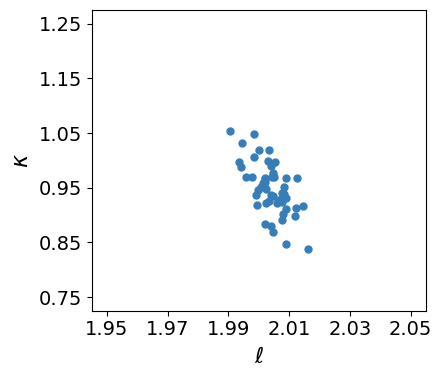

In [22]:
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.scatter(update_samples[:,0], update_samples[:,1])
plt.scatter([np.min(XX), np.min(XX), np.max(XX), np.max(XX)],
            [np.min(YY), np.max(YY), np.min(YY), np.max(YY)],
            color='w')
plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_rejection.png', bbox_inches='tight')

In [23]:
# update_KDE = GKDE(update_samples.T)

# for ii in range(np.shape(ZZ)[0]):
#     for jj in range(np.shape(ZZ)[1]):
#         ZZ[ii, jj] = update_KDE([XX[ii,jj],YY[ii,jj]])
# #ZZ = update_KDE(XX, YY)
# plt.contourf(XX, YY, ZZ, levels=10);

# #plt.contourf(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

# ax = plt.gca()
# ax.set_aspect(0.18)

# plt.xlim(1.945, 2.055)
# plt.ylim(0.725, 1.275)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\kappa$')
# plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
#            labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
# plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
#            labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

# plt.tight_layout()
# plt.savefig(f'/Users/kirana/Desktop/work/paper/rejection_KDE.png', bbox_inches='tight')

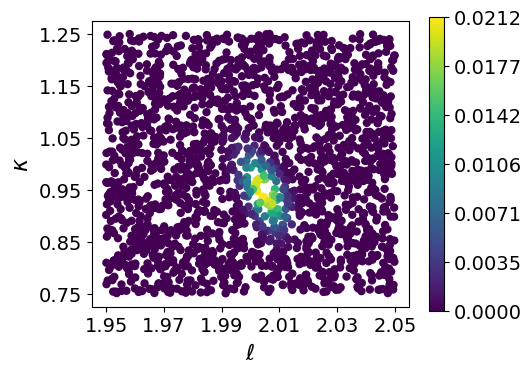

In [24]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_density.png', bbox_inches='tight')

## Binning methods

In [33]:
n_bins = 16

### Regular partitioning

In [34]:
rpartitioned_w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),2)),
                                                                        n_bins=n_bins)

sum binning = 256.0000000000001
sum binning = 256.0000000000001


In [35]:
print(np.sum(rpartitioned_w)/35)

0.02856215772807305


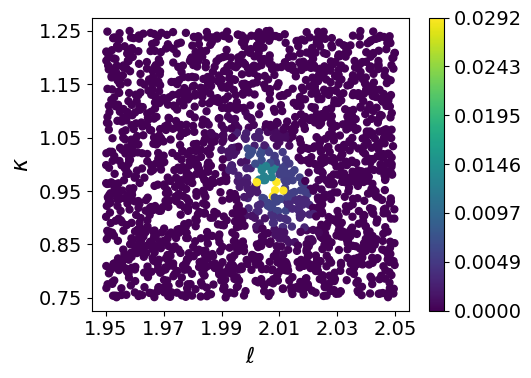

In [36]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=rpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_rbinning.png', bbox_inches='tight')

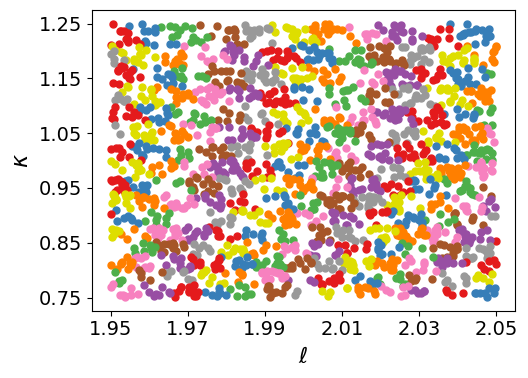

In [37]:
for i in range(n_bins*n_bins):
    plt.scatter(init_samples[(bins==i),0],init_samples[(bins==i),1])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_rcells.png', bbox_inches='tight')

### K-means partitioning

In [38]:
n_clusters = 220
kpartitioned_w, clusters, centers, w_center = weights.computePartitionedWeights_kMeans_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),2)),
                                                                        n_clusters=n_clusters)

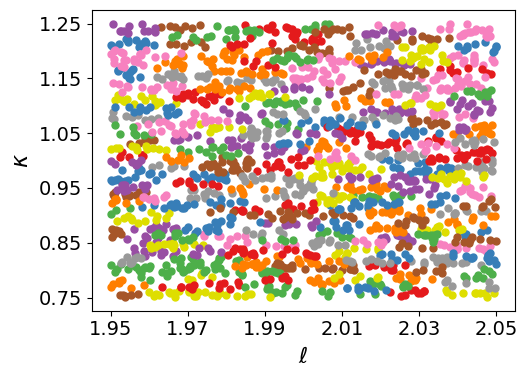

In [39]:
for i in range(n_clusters):
    plt.scatter(init_samples[(clusters==i),0], init_samples[(clusters==i),1])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_kcells.png', bbox_inches='tight')

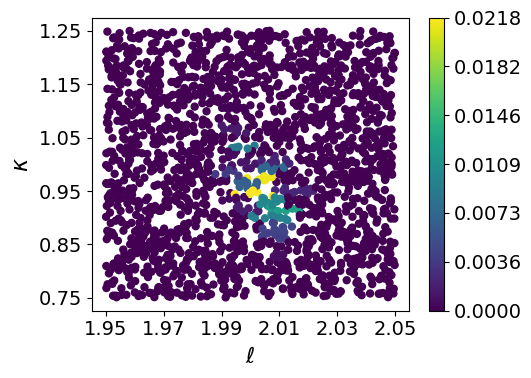

In [40]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=kpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w),
                                                             np.max(kpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_kbinning.png', bbox_inches='tight')

In [53]:
w = weights.computePartitionedWeights_kMeans_iterative(init_samples, pred_samples,
                                                       sample_set_2=obs_samples, n_clusters=28)

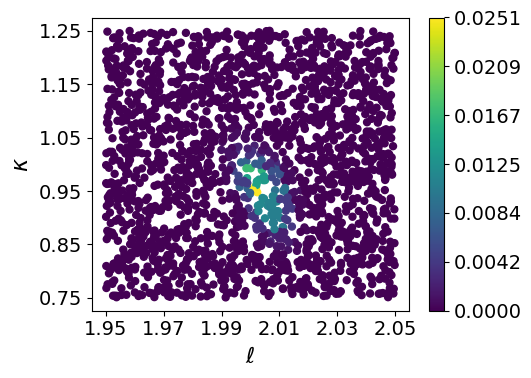

In [54]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w),
                                                             np.max(w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_kiter.png', bbox_inches='tight')

In [35]:
w = weights.computePartitionedWeights_regulargrid_iterative(init_samples, pred_samples,
                                                       sample_set_2=obs_samples, n_clusters=25)

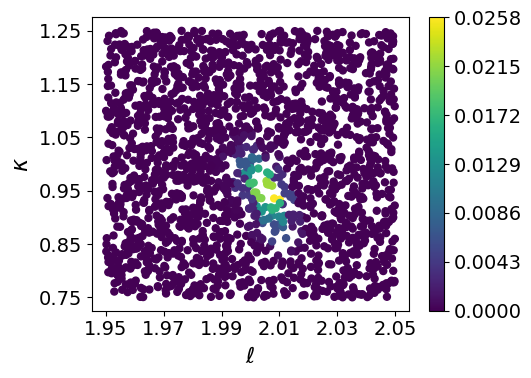

In [36]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w),
                                                             np.max(w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/iterative_heat_riter.png', bbox_inches='tight')